In [1]:
# imports used throughout this notebook
from pyspark.sql import DataFrame, Column, Window
from pyspark.sql.types import IntegerType
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.graphics.api import abline_plot
import pandas as pd
import os
import sys

# add homemade helpers
sys.path.insert(1, '../../scripts')
import helpers.join_helpers as jh
import helpers.plot_helpers as ph

# path where the data files are stored
DATA_PATH = '../../data'

In [2]:
from pyspark.sql import SparkSession

# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName('MAST30034 XT Project 1')
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config('spark.sql.repl.eagerEval.enabled', True) 
    .config('spark.sql.parquet.cacheMetadata', 'true')
    .config("spark.executor.memory", "2g")
    .config("spark.driver.memory", "4g")
    .getOrCreate()
)

22/08/19 02:44:30 WARN Utils: Your hostname, Polaris resolves to a loopback address: 127.0.1.1; using 172.18.171.75 instead (on interface eth0)
22/08/19 02:44:30 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/08/19 02:44:32 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# read in the aggregated covid data
covid_df = spark.read.parquet(f'{DATA_PATH}/curated/virals/covid/aggregated/cases_by_week')
covid_df.limit(5)

week_year,week_month,week_ending,week_index,timeline,borough,population,tot_cases,tot_pc_cases,tot_p100k_cases
2020,11,2020-11-07,149,2,Staten Island,495522.0,699.0,0.001410633634833...,141.06336348335694
2021,5,2021-05-29,178,2,Staten Island,493494.0,177.0,3.586669746744641...,35.866697467446414
2020,4,2020-04-04,118,1,Staten Island,495522.0,2188.0,0.004415545626632118,441.5545626632117
2020,7,2020-07-25,134,2,Staten Island,495522.0,158.0,3.188556713929956...,31.885567139299567
2021,3,2021-03-13,167,2,Staten Island,493494.0,1532.0,0.003104394379668...,310.4394379668243


In [4]:
# read in the aggregated covid data
flu_df = spark.read.parquet(f'{DATA_PATH}/curated/virals/flu/aggregated/cases_by_week')
flu_df.limit(5)

week_year,week_month,week_ending,week_index,timeline,borough,population,tot_cases,tot_pc_cases,tot_p100k_cases
2019,1,2019-01-05,53,1,Bronx,1418207.0,495.0,3.490322639783896E-4,34.903226397838964
2019,10,2019-10-19,94,1,Bronx,1418207.0,6.0,4.230694108828965E-6,0.4230694108828965
2019,10,2019-10-12,93,1,Bronx,1418207.0,12.0,8.46138821765793E-6,0.846138821765793
2019,3,2019-03-23,64,1,Bronx,1418207.0,488.0,3.440964541847558...,34.409645418475584
2019,11,2019-11-23,99,1,Bronx,1418207.0,203.0,1.431384840153799...,14.313848401537998


In [5]:
# read in the aggregated yellow tlc data
tlc_pu_df = spark.read.parquet(f'{DATA_PATH}/curated/tlc/aggregated/yellow/by_pu')
tlc_pu_df.limit(5)

week_year,week_month,week_ending,week_index,timeline,pu_borough,population,num_trips,num_pc_trips,num_p100k_trips,avg_passengers,avg_trip_distance
2020,9,2020-09-19,142,2,Brooklyn,2727393.0,2290,8.396296389995868E-4,83.96296389995868,1.3458515283842796,2.9860742358078567
2021,2,2021-02-20,164,2,Manhattan,1576876.0,291970,0.1851572349379406,18515.72349379406,1.4186286262287222,2.1355327944651927
2020,9,2020-09-19,142,2,Staten Island,495522.0,39,7.870488091346096E-5,7.870488091346096,1.0,31.242307692307698
2021,1,2021-01-09,158,2,Staten Island,493494.0,55,1.114501898705962E-4,11.14501898705962,1.0363636363636364,30.25254545454545
2020,9,2020-09-26,143,2,Bronx,1466438.0,904,6.164597480425358E-4,61.64597480425357,1.3152654867256637,3.758019911504429


In [6]:
# join the datasets by week_index
joined_pu_df = jh.join_by_week_by_borough(tlc_pu_df, covid_df, 'covid')
joined_pu_df = jh.join_by_week_by_borough(joined_pu_df, flu_df, 'flu')

In [7]:
# filter for only timeline 2
joined_pu_df = joined_pu_df.where(F.col('timeline') == 2)

In [8]:
joined_pu_df.limit(5)

22/08/19 02:44:39 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


week_year,week_month,week_ending,week_index,timeline,pu_borough,population,num_trips,num_pc_trips,num_p100k_trips,avg_passengers,avg_trip_distance,covid_week_year,covid_week_month,covid_week_ending,covid_week_index,covid_timeline,covid_borough,covid_population,covid_tot_cases,covid_tot_pc_cases,covid_tot_p100k_cases,flu_week_year,flu_week_month,flu_week_ending,flu_week_index,flu_timeline,flu_borough,flu_population,flu_tot_cases,flu_tot_pc_cases,flu_tot_p100k_cases
2020,9,2020-09-19,142,2,Brooklyn,2727393.0,2290,8.396296389995868E-4,83.96296389995868,1.3458515283842796,2.9860742358078567,2020,9,2020-09-12,141,2,Brooklyn,2727393.0,693.0,2.540887946841544...,25.408879468415442,null,null,null,null,null,null,null,null,null,null
2021,2,2021-02-20,164,2,Manhattan,1576876.0,291970,0.1851572349379406,18515.72349379406,1.4186286262287222,2.1355327944651927,2021,2,2021-02-13,163,2,Manhattan,1576876.0,3218.0,0.002040743850499...,204.07438504993416,2021,2,2021-02-13,163,2,Manhattan,1576876.0,3.0,1.902495820850846...,0.1902495820850847
2020,9,2020-09-19,142,2,Staten Island,495522.0,39,7.870488091346096E-5,7.870488091346096,1.0,31.242307692307698,2020,9,2020-09-12,141,2,Staten Island,495522.0,148.0,2.986749326972364...,29.867493269723646,null,null,null,null,null,null,null,null,null,null
2021,1,2021-01-09,158,2,Staten Island,493494.0,55,1.114501898705962E-4,11.14501898705962,1.0363636363636364,30.25254545454545,2020,12,2021-01-02,157,2,Staten Island,495522.0,2941.0,0.005935155250422787,593.5155250422787,2020,12,2021-01-02,157,2,Staten Island,495522.0,4.0,8.072295478303688E-6,0.8072295478303688
2020,9,2020-09-26,143,2,Bronx,1466438.0,904,6.164597480425358E-4,61.64597480425357,1.3152654867256637,3.758019911504429,2020,9,2020-09-19,142,2,Bronx,1466438.0,352.0,2.400374240165625...,24.003742401656257,null,null,null,null,null,null,null,null,null,null


In [9]:
# remove all columns except those being fitted
joined_pu_df = joined_pu_df.select(
    F.col('avg_trip_distance'),
    (F.col('week_index') - 1).alias('pre_week_ending'),
    F.col('pu_borough'),
    F.col('covid_tot_p100k_cases'),
    F.col('flu_tot_p100k_cases')
)

In [17]:
# convert the dataframe to pandas type
joined_pu_df = joined_pu_df.toPandas()

In [18]:
model = ols(
    formula = 'avg_trip_distance ~ pre_week_ending + pu_borough * covid_tot_p100k_cases + pu_borough * flu_tot_p100k_cases',
    data = joined_pu_df
).fit()


In [19]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:      avg_trip_distance   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     936.6
Date:                Fri, 19 Aug 2022   Prob (F-statistic):          6.30e-143
Time:                        02:47:47   Log-Likelihood:                -235.95
No. Observations:                 170   AIC:                             503.9
Df Residuals:                     154   BIC:                             554.1
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------

In [20]:
table = sm.stats.anova_lm(model, typ=2)
table

,sum_sq,df,F,PR(>F)
pu_borough,12684.293728,4.0,3056.468500,1.537003e-145
pre_week_ending,0.974510,1.0,0.939290,3.339801e-01
covid_tot_p100k_cases,38.206126,1.0,36.825328,9.635711e-09
pu_borough:covid_tot_p100k_cases,24.558254,4.0,5.917675,1.862774e-04
flu_tot_p100k_cases,0.637668,1.0,0.614622,4.342569e-01
pu_borough:flu_tot_p100k_cases,1.469776,4.0,0.354164,8.408334e-01
Residual,159.774363,154.0,NaN,NaN


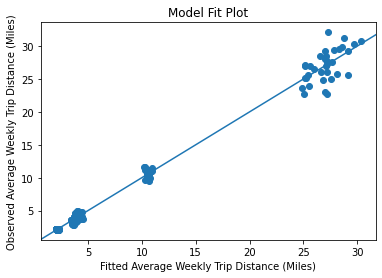

In [32]:
fig, ax = plt.subplots()
ax.scatter(model.predict(), joined_pu_df['avg_trip_distance'].iloc[model.fittedvalues.index])
line_fit = sm.OLS(joined_pu_df['avg_trip_distance'].iloc[model.fittedvalues.index], 
    sm.add_constant(model.predict(), prepend=True)).fit()
abline_plot(model_results=line_fit, ax=ax)


ax.set_title('Model Fit Plot')
ax.set_ylabel('Observed Average Weekly Trip Distance (Miles)')
ax.set_xlabel('Fitted Average Weekly Trip Distance (Miles)');

# show and save the plot
plt.savefig(
    f'../../plots/diagnostic-{ax.get_ylabel()}-vs-{ax.get_xlabel()}.png',
    bbox_inches='tight',
    dpi=300
)
plt.show()